In [1]:
import datetime
import math
import warnings
from zipfile import ZipFile

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import geopandas
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas
import requests
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from local_module import (
    MapTemplate,
    NhcDownloaderBot,
    NhcDownloaderBotNEW,
    NhcRssParser,
    align_paragraph,
    calcBearing,
    feature_distance,
    fecha_hora,
    tc_legend,
)
from matplotlib.pyplot import imread
from pyproj import CRS
from shapely.geometry import LineString, MultiPoint, Point, Polygon

%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# nch_dl       = NhcDownloaderBot()
map_template = MapTemplate()
# df = nch_dl.gdf_file(1, 2022)

In [3]:
# nch_dl       = NhcDownloaderBotNEW()

# gtwo_areas_gdf = nch_dl.gtw_gdf()[0]

# gtwo_areas_gdf

#DOCE se vigila? True
{'AL122022': ['#DOCE', 'La DT', [18.0, -33.4], 'ONO a 13 mph', '1007 mb', '35 mph', 'Thu, 06 Oct 2022 08:45:39 GMT', '5:00 AM AST Thu Oct 6', 'Vigila', 3910, 'E']}
No Points
No Points
Area 1 se vigila? True
{'AL122022': ['#DOCE', 'La DT', [18.0, -33.4], 'ONO a 13 mph', '1007 mb', '35 mph', 'Thu, 06 Oct 2022 08:45:39 GMT', '5:00 AM AST Thu Oct 6', 'Vigila', 3910, 'E'], 'Area 1': ['Vigila', 920, 'SSE']}


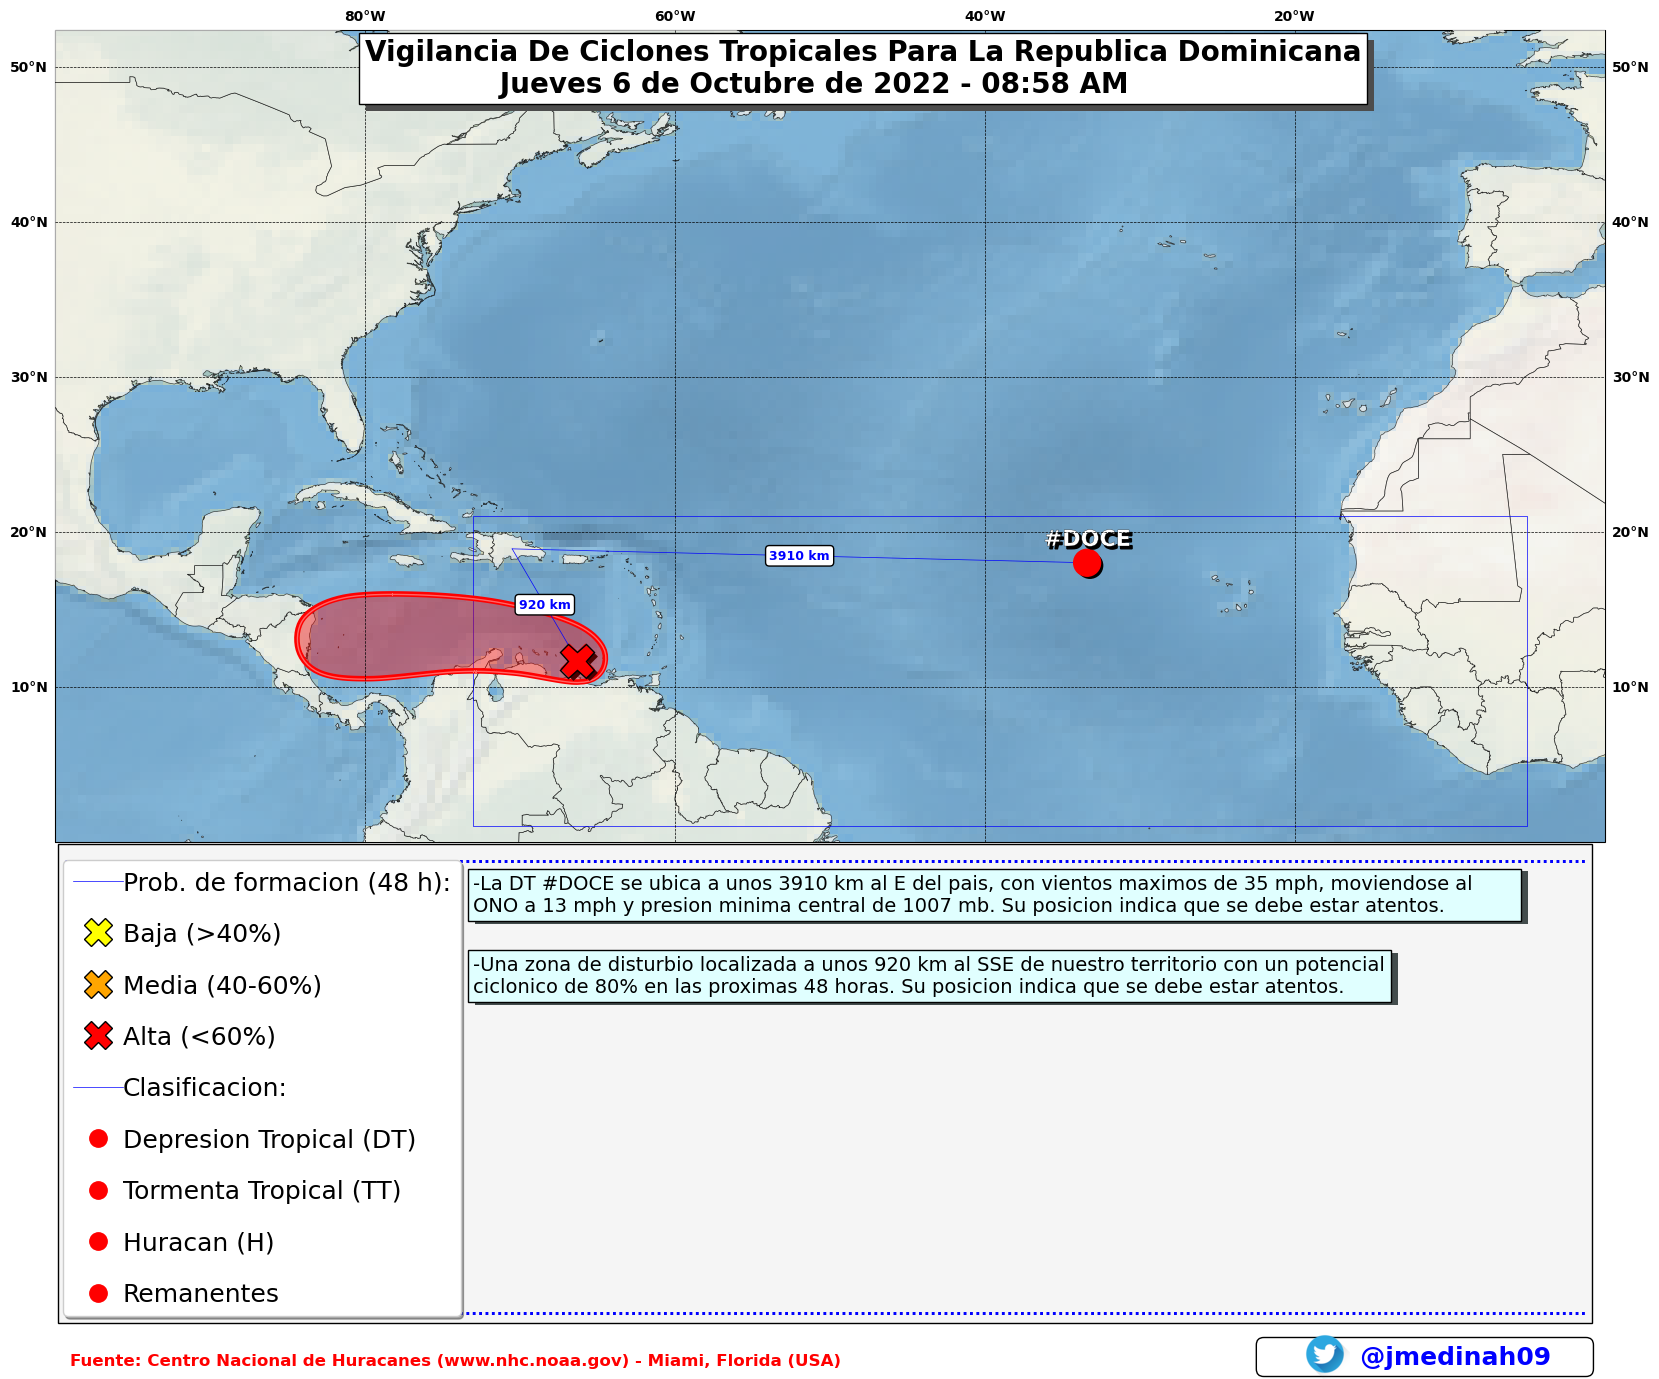

In [4]:
fig, ax = map_template.wide_map()
ax = tc_legend(ax)
fecha_y_hora = fecha_hora(ax)

nch_dl = NhcDownloaderBotNEW()

gtwo_areas_gdf = nch_dl.gtw_gdf()[0].loc[
    nch_dl.gtw_gdf()[0]["BASIN"] == "Atlantic"
]  # Areas
gtwo_lines_gdf = nch_dl.gtw_gdf()[1].loc[
    nch_dl.gtw_gdf()[1]["BASIN"] == "Atlantic"
]  # lines
gtwo_points_gdf = nch_dl.gtw_gdf()[2].loc[
    nch_dl.gtw_gdf()[2]["BASIN"] == "Atlantic"
]  # Points
# gtwo_areas_gdf  = nch_dl.gtwo_areas_gdf .loc[nch_dl .gtwo_areas_gdf  ['BASIN']     == 'Atlantic']
# gtwo_lines_gdf  = nch_dl.gtwo_lines_gdf .loc[nch_dl .gtwo_lines_gdf  ['BASIN']     == 'Atlantic']
# gtwo_points_gdf = nch_dl.gtwo_points_gdf.loc[nch_dl .gtwo_points_gdf ['BASIN']     == 'Atlantic']

polygon = Polygon([(-73, 1), (-73, 21), (-5, 21), (-5, 1), (-73, 1)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=gtwo_areas_gdf.crs)
ax.add_geometries(
    poly_gdf["geometry"],
    crs=map_template.data_crs,
    facecolor="none",
    edgecolor="b",
    linewidth=0.5,
    zorder=100,
)

# https://matplotlib.org/stable/tutorials/advanced/patheffects_guide.html
url = "https://www.nhc.noaa.gov/index-at.xml"
tcdict, tclist = {}, []
try:
    tcdict, tclist = NhcRssParser(url).tc_dict_list()
    for key, value in tcdict.items():

        lat, lon = tcdict[key][2]
        name = tcdict[key][0]

        p = Point(lon, lat)
        inside = p.within(polygon)
        if inside == True:
            value.append("Vigila")
        else:
            value.append("Informa que")
        print(name, "se vigila?", p.within(polygon))

        ax, distance = feature_distance(lat, lon, ax)
        value.append(distance)

        bearing = calcBearing(lat, lon)
        value.append(bearing)

        if value[1] == "el PCT":
            ax.scatter(
                lon,
                lat,
                transform=map_template.data_crs,
                color="red",
                s=550,
                marker="X",
                zorder=10000,
                path_effects=[
                    path_effects.withSimplePatchShadow(offset=(3, -3), alpha=1)
                ],
            )
            ax.plot(
                lon,
                lat,
                transform=map_template.data_crs,
                markersize=25,
                marker="X",
                markeredgecolor="black",
                markerfacecolor="none",
                linestyle="none",
                zorder=10000,
            )
            t = ax.text(
                lon,
                lat + 1.5,
                name.upper(),
                transform=ax.transData,
                fontsize=16,
                verticalalignment="center",
                horizontalalignment="center",
                weight="bold",
                color="w",
                zorder=10000,
            )
            t.set_path_effects(
                [
                    path_effects.PathPatchEffect(offset=(2, -2), facecolor="k"),
                    path_effects.PathPatchEffect(
                        edgecolor="k", linewidth=0.2, facecolor="w"
                    ),
                ]
            )
        else:
            ax.scatter(
                lon,
                lat,
                transform=map_template.data_crs,
                color="red",
                marker=".",
                s=1500,
                path_effects=[
                    path_effects.withSimplePatchShadow(shadow_rgbFace="k", alpha=1)
                ],
                zorder=10000,
            )
            t = ax.text(
                lon,
                lat + 1.5,
                name.upper(),
                transform=ax.transData,
                fontsize=16,
                verticalalignment="center",
                horizontalalignment="center",
                weight="bold",
                color="w",
                zorder=10000,
            )
            t.set_path_effects(
                [
                    path_effects.PathPatchEffect(offset=(2, -2), facecolor="k"),
                    path_effects.PathPatchEffect(
                        edgecolor="k", linewidth=0.2, facecolor="w"
                    ),
                ]
            )
except:  # I have to specify the actual error that is going to catch here
    print("No TC found")
print(tcdict)
# ***********************************************************************************************************************
prob_colors = {"Low": "yellow", "Medium": "orange", "High": "red"}
for prob_type in prob_colors.keys():
    prob_subset_areas = gtwo_areas_gdf[gtwo_areas_gdf["RISK2DAY"] == prob_type]
    prob_subset_points = gtwo_points_gdf[gtwo_points_gdf["RISK2DAY"] == prob_type]
    prob_subset_lines = gtwo_lines_gdf[gtwo_lines_gdf["RISK2DAY"] == prob_type]
    if prob_subset_points.empty:
        print("No Points")
    else:
        ax.add_geometries(
            prob_subset_areas["geometry"],
            facecolor="none",
            edgecolor=prob_colors[prob_type],
            crs=map_template.data_crs,
            linewidth=4,
            zorder=100,
        )
        ax.add_geometries(
            prob_subset_areas["geometry"],
            facecolor=prob_colors[prob_type],
            edgecolor="w",
            crs=map_template.data_crs,
            linewidth=1,
            alpha=0.4,
            zorder=100,
        )
    ax.scatter(
        prob_subset_points["geometry"].x,
        prob_subset_points["geometry"].y,
        transform=map_template.data_crs,
        color=prob_colors[prob_type],
        s=550,
        marker="X",
        zorder=10000,
        path_effects=[path_effects.withSimplePatchShadow(offset=(3, -3), alpha=1)],
    )
    ax.add_geometries(
        prob_subset_lines["geometry"],
        crs=map_template.data_crs,
        facecolor="none",
        edgecolor=prob_colors[prob_type],
        linewidth=2,
        zorder=10000,
    )
if gtwo_points_gdf.empty:
    print("No points")
else:
    ax.plot(
        gtwo_points_gdf["geometry"].x,
        gtwo_points_gdf["geometry"].y,
        transform=map_template.data_crs,
        markersize=25,
        marker="X",
        markeredgecolor="black",
        markerfacecolor="none",
        linestyle="none",
        zorder=10000,
    )
lon = list(gtwo_points_gdf["geometry"].x)
lat = list(gtwo_points_gdf["geometry"].y)
for i, coords in enumerate(zip(lon, lat)):
    point = Point(coords)
    point_gdf = geopandas.GeoDataFrame([1], geometry=[point], crs=gtwo_areas_gdf.crs)
    inside = list(point_gdf["geometry"])[0].within(list(poly_gdf["geometry"])[0])
    if inside == True:
        tcdict[f"Area {str(i+1)}"] = ["Vigila"]
    else:
        tcdict[f"Area {str(i+1)}"] = ["Observa"]
    print(f"Area {str(i+1)} se vigila? {inside}")

    lat, lon = coords[1], coords[0]
    ax, distance = feature_distance(lat, lon, ax)
    tcdict[f"Area {str(i+1)}"].append(distance)

    bearing = calcBearing(lat, lon)
    tcdict[f"Area {str(i+1)}"].append(bearing)
print(tcdict)
# ************************************************************************************************************************
props = dict(
    facecolor="azure",
    path_effects=[path_effects.withSimplePatchShadow(offset=(5, -2), alpha=1)],
)
p = 0
xtxt = 0.27
ytxt = -0.04
for key, value in tcdict.items():
    if "AL" in key:
        if tcdict[key][8] == "Vigila":
            # recomendacion = 'Por su posicion se recomienda estar atentos a nuestros proximos boletines.'
            recomendacion = "Su posicion indica que se debe estar atentos."
            props = dict(
                facecolor="lightcyan",
                path_effects=[
                    path_effects.withSimplePatchShadow(offset=(5, -2), alpha=1)
                ],
            )
            word_1 = "que" #Si se vigila: "que se ubica a unos"
        else:
            # recomendacion = 'Por su posicion no representa peligro para nuestro territorio.'
            recomendacion = (
                "Su posicion indica que es poco probable que afecte el pais."
            )
            word_1 = "" #si no se vigila

        text = f"""-{tcdict[key][1]} {tcdict[key][0]} se ubica a unos {tcdict[key][9]} km al {tcdict[key][10]} del pais, con vientos maximos de {tcdict[key][5]}, moviendose al       
{tcdict[key][3]} y presion minima central de {tcdict[key][4]}. {recomendacion}"""

        ax.text(
            xtxt,
            ytxt,
            text,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment="top",
            bbox=props,
            color="black",
            zorder=100,
        )
        ytxt = ytxt - 0.1
    else:
        if tcdict[key][0] == "Vigila":
            # recomendacion = 'Por su posicion se recomienda estar atentos a las nuestros\nproximos boletines.'
            recomendacion = "Su posicion indica que se debe estar atentos."
        else:
            # recomendacion = 'Por su posicion no representa peligro para\nel pais.'
            recomendacion = (
                "Su posicion indica que es poco probable que afecte el pais."
            )
        text = f"""-Una zona de disturbio localizada a unos {tcdict[key][1]} km al {tcdict[key][2]} de nuestro territorio con un potencial
ciclonico de {gtwo_points_gdf['PROB2DAY'][0]} en las proximas 48 horas. {recomendacion}"""

        ax.text(
            xtxt,
            ytxt,
            text.rjust(10),
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment="top",
            bbox=props,
            color="black",
            zorder=100,
        )
        ytxt = ytxt - 0.1
fig.savefig("gtwo", bbox_inches="tight")
# plt.gcf()
# plt.savefig(f"gtwo", bbox_inches="tight", pad_inches=0, dpi=300)

In [9]:
# LAURA 2020
track_line_gdf_a = geopandas.read_file(
    "example_shp/al132020_5day_011/al132020-011_5day_lin.shp"
)
cone_gdf_a = geopandas.read_file(
    "example_shp/al132020_5day_011/al132020-011_5day_pgn.shp"
)
points_gdf_a = geopandas.read_file(
    "example_shp/al132020_5day_011/al132020-011_5day_pts.shp"
)

init_radii_gdf_a = geopandas.read_file(
    "example_shp/al132020_fcst_011/al132020_2020082215_initialradii.shp"
)
fcst_radii_gdf_a = geopandas.read_file(
    "example_shp/al132020_fcst_011/al132020_2020082215_forecastradii.shp"
)

best_track_points_gdf_a = geopandas.read_file(
    "example_shp/al132020_best_track/AL132020_pts.shp"
)
best_track_line_gdf_a = geopandas.read_file(
    "example_shp/al132020_best_track/AL132020_lin.shp"
)
best_track_radii_gdf_a = geopandas.read_file(
    "example_shp/al132020_best_track/AL132020_radii.shp"
)
best_track_swath_gdf_a = geopandas.read_file(
    "example_shp/al132020_best_track/AL132020_windswath.shp"
)

wsp_34_gdf_a = geopandas.read_file(
    "example_shp/2020082212_wsp_120hr/2020082212_wsp34knt120hr_5km.shp"
)
wsp_50_gdf_a = geopandas.read_file(
    "example_shp/2020082212_wsp_120hr/2020082212_wsp50knt120hr_5km.shp"
)
wsp_64_gdf_a = geopandas.read_file(
    "example_shp/2020082212_wsp_120hr/2020082212_wsp64knt120hr_5km.shp"
)

gtwo_areas_gdf_a = geopandas.read_file(
    "example_shp/gtwo_shapefiles/gtwo_areas_202108261157.shp"
)
gtwo_lines_gdf_a = geopandas.read_file(
    "example_shp/gtwo_shapefiles/gtwo_lines_202108261157.shp"
)
gtwo_points_gdf_a = geopandas.read_file(
    "example_shp/gtwo_shapefiles/gtwo_points_202108261157.shp"
)

In [6]:
# MICHAEL 2018
track_line_gdf_b = geopandas.read_file(
    "zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_lin.shp"
)
cone_gdf_b = geopandas.read_file(
    "zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_pgn.shp"
)
points_gdf_b = geopandas.read_file(
    "zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_pts.shp"
)

init_radii_gdf_b = geopandas.read_file(
    "zip://./example_shp/michael_2018/al142018_fcst_012.zip!al142018_2018100915_initialradii.shp"
)
fcst_radii_gdf_b = geopandas.read_file(
    "zip://./example_shp/michael_2018/al142018_fcst_012.zip!al142018_2018100915_forecastradii.shp"
)

best_track_points_gdf = geopandas.read_file('example_shp/michael_2018')
best_track_line_gdf   = geopandas.read_file('example_shp/michael_2018')
best_track_radii_gdf  = geopandas.read_file('example_shp/michael_2018')
best_track_swath_gdf  = geopandas.read_file('example_shp/michael_2018')

wsp_34_gdf            = geopandas.read_file('example_shp/michael_2018')
wsp_50_gdf            = geopandas.read_file('example_shp/michael_2018')
wsp_64_gdf            = geopandas.read_file('example_shp/michael_2018')

DriverError: 'example_shp/michael_2018' not recognized as a supported file format.

In [ ]:
def gtwo_plot(ax, gtwo_points_gdf, gtwo_lines_gdf, gtwo_areas_gdf):
    prob_colors = {"Low": "yellow", "Medium": "orange", "High": "red"}
    for prob_type in prob_colors.keys():
        prob_subset_areas = gtwo_areas_gdf[gtwo_areas_gdf["RISK2DAY"] == prob_type]
        prob_subset_points = gtwo_points_gdf[gtwo_points_gdf["RISK2DAY"] == prob_type]
        prob_subset_lines = gtwo_lines_gdf[gtwo_lines_gdf["RISK2DAY"] == prob_type]
        ax.add_geometries(
            prob_subset_areas["geometry"],
            facecolor="none",
            edgecolor=prob_colors[prob_type],
            crs=map_template.data_crs,
            linewidth=4,
            zorder=10000,
        )
        ax.add_geometries(
            prob_subset_areas["geometry"],
            facecolor=prob_colors[prob_type],
            edgecolor="w",
            crs=map_template.data_crs,
            linewidth=1,
            alpha=0.4,
            zorder=10000,
        )
        ax.scatter(
            prob_subset_points["geometry"].x,
            prob_subset_points["geometry"].y,
            transform=map_template.data_crs,
            color=prob_colors[prob_type],
            s=550,
            marker="X",
            zorder=10001,
            path_effects=[path_effects.withSimplePatchShadow(offset=(3, -3), alpha=1)],
        )
        ax.add_geometries(
            prob_subset_lines["geometry"],
            crs=map_template.data_crs,
            facecolor="none",
            edgecolor=prob_colors[prob_type],
            linewidth=2,
            zorder=10001,
        )
    if gtwo_points_gdf.empty:
        print("No points")
    else:
        ax.plot(
            gtwo_points_gdf["geometry"].x,
            gtwo_points_gdf["geometry"].y,
            transform=map_template.data_crs,
            markersize=25,
            marker="X",
            markeredgecolor="black",
            markerfacecolor="none",
            linestyle="none",
            zorder=10001,
        )
    return ax


def cone_plot(
    ax,
    cone_gdf,
    track_line_gdf,
    points_gdf,
    init_radii_gdf=None,
    fcst_radii_gdf=None,
    plot_radii=False,
):
    ax.add_geometries(
        cone_gdf["geometry"],
        crs=map_template.data_crs,
        facecolor="white",
        edgecolor="none",
        alpha=0.2,
        zorder=10001,
    )
    ax.add_geometries(
        cone_gdf["geometry"],
        crs=map_template.data_crs,
        facecolor="none",
        edgecolor="k",
        linewidth=0.5,
        zorder=10001,
    )
    ax.add_geometries(
        track_line_gdf["geometry"],
        crs=map_template.data_crs,
        facecolor="none",
        edgecolor="b",
        linewidth=2,
        zorder=10001,
    )
    sc = ax.scatter(
        points_gdf["LON"],
        points_gdf["LAT"],
        transform=map_template.data_crs,
        c="b",
        zorder=10002,
    )

    #     buffer_distance = 50
    #     fcst_radii_gdf_dis = fcst_radii_gdf.dissolve(by='RADII')
    #     # fcst_radii_gdf_a_dis = fcst_radii_gdf_a_dis.buffer(distance=1, join_style=1, cap_style=1).simplify(1)
    #     fcst_radii_gdf_dis = fcst_radii_gdf_dis.buffer(buffer_distance, join_style=1).buffer(-buffer_distance, join_style=1)
    #     ax.add_geometries(fcst_radii_gdf_dis, crs=map_template.data_crs,
    #                           color=['#6969FF', '#0000FF', '#000080'], alpha=0.5)
    #     if plot_radii:
    #         ax.add_geometries(init_radii_gdf['geometry'], crs=map_template.data_crs, facecolor='brown',
    #                           edgecolor='none', linewidth=0.1, alpha=0.5, zorder = 10001)
    #         ax.add_geometries(fcst_radii_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
    #                           edgecolor='black', linewidth=1)
    return ax

In [ ]:
fig, ax = map_template.zoomed_map()
fecha_y_hora = fecha_hora(ax)
ax = tc_legend(ax)

cone_gdf          = nch_dl.cone_gdf()[0]
track_lines_gdf   = nch_dl.cone_gdf()[1]
points_points_gdf = nch_dl.cone_gdf()[2]


ax = cone_plot(
    ax,
    cone_gdf,
    track_lines_gdf,
    points_points_gdf)


In [ ]:
fig, ax = map_template.wide_map()
fecha_y_hora = fecha_hora(ax)
ax = tc_legend(ax)
ax = gtwo_plot(ax, gtwo_points_gdf_a, gtwo_lines_gdf_a, gtwo_areas_gdf_a)

# ax = cone_plot(ax, cone_gdf_a, track_line_gdf_a, points_gdf_a, init_radii_gdf_a)
# ax = cone_plot(ax, cone_gdf_b, track_line_gdf_b, points_gdf_b, init_radii_gdf_b)

ax = cone_plot(
    ax,
    cone_gdf_a,
    track_line_gdf_a,
    points_gdf_a,
    init_radii_gdf_a,
    fcst_radii_gdf_a,
    plot_radii=True,
)
ax = cone_plot(
    ax,
    cone_gdf_b,
    track_line_gdf_b,
    points_gdf_b,
    init_radii_gdf_b,
    fcst_radii_gdf_b,
    plot_radii=True,
)

In [ ]:
fig, ax = map_template.wide_map()
fecha_y_hora = fecha_hora(ax)
ax = tc_legend(ax)

ax = cone_plot(
    ax,
    cone_gdf_a,
    track_line_gdf_a,
    points_gdf_a,
    init_radii_gdf_a,
    fcst_radii_gdf_a,
    plot_radii=False,
)
# ax = cone_plot(ax, cone_gdf_b, track_line_gdf_b, points_gdf_b)

# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a.to_crs("EPSG:32634")
# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a_buffer.buffer(distance=0.1)
# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a_buffer.to_crs("EPSG:4035")

buffer_distance = 50
fcst_radii_gdf_dis = fcst_radii_gdf_a.dissolve(by="RADII")
# fcst_radii_gdf_a_dis = fcst_radii_gdf_a_dis.buffer(distance=1, join_style=1, cap_style=1).simplify(1)
fcst_radii_gdf_dis = fcst_radii_gdf_dis.buffer(buffer_distance, join_style=1).buffer(
    -buffer_distance, join_style=1
)
ax.add_geometries(
    fcst_radii_gdf_dis,
    crs=map_template.data_crs,
    alpha=0.5,
    color=["#6969FF", "#0000FF", "#000080"],
)


# ax.add_geometries(fcst_radii_gdf_a['geometry'], crs=map_template.data_crs, facecolor='none',
#                    edgecolor='black', linewidth=1)
ax.add_geometries(
    track_line_gdf_a["geometry"],
    crs=map_template.data_crs,
    facecolor="none",
    edgecolor="k",
    linewidth=2,
    zorder=10001,
)


# track_line_gdf_a_buffer = track_line_gdf_a.to_crs("EPSG:32634")
# track_line_gdf_a_buffer = track_line_gdf_a_buffer.buffer(distance=150000)
# track_line_gdf_a_buffer = track_line_gdf_a_buffer.to_crs("EPSG:4035")
# ax.add_geometries(track_line_gdf_a_buffer, crs=map_template.data_crs,
#                       facecolor='#C8A2C8', alpha=1)
# ax.add_geometries(fcst_radii_gdf_a_buffer, crs=map_template.data_crs,
#                       facecolor='none', edgecolor='k', alpha=0.5)

In [ ]:
fig, ax = map_template().wide_map()
silueta_rd_gdf_buffer = map_template.silueta_rd_gdf.to_crs("EPSG:32634")
silueta_rd_gdf_buffer = silueta_rd_gdf_buffer.buffer(distance=300000)
silueta_rd_gdf_buffer = silueta_rd_gdf_buffer.to_crs("EPSG:4035")
ax.add_geometries(
    silueta_rd_gdf_buffer, crs=map_template.data_crs, facecolor="white", alpha=0.3
)

In [ ]:
fcst_radii_gdf_dis

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

ax.set_extent([-100, -20, 10, 40])
# ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
# ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
#                  edgecolor='none', alpha = 0.5)
# ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=0.5, alpha=0.7)
# ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=1, alpha=0.7)

ax.add_geometries(
    gdf_names[file_names[0]][1]["geometry"],
    crs=data_crs,
    facecolor="white",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)
ax.add_geometries(
    gdf_names[file_names[0]][0]["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=2,
)
sc = ax.scatter(
    gdf_names[file_names[0]][2]["LON"],
    gdf_names[file_names[0]][2]["LAT"],
    transform=data_crs,
    zorder=10,
    c=gdf_names[file_names[0]][2]["MAXWIND"],
)
ax.add_geometries(
    gdf_names[file_names[1]][0]["geometry"],
    crs=data_crs,
    facecolor="brown",
    edgecolor="none",
    linewidth=0.1,
    alpha=0.5,
)
ax.add_geometries(
    gdf_names[file_names[1]][1]["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
)

# ww_colors = {'TWA': 'yellow',
#              'HWA': 'pink',
#              'TWR': 'blue',
#              'HWR': 'tab:red'}

# for ww_type in ww_colors.keys():
#     ww_subset = ww_gdf[ww_gdf['TCWW']==ww_type]
#     ax.add_geometries(ww_subset['geometry'], facecolor='none',
#                      edgecolor=ww_colors[ww_type], crs=data_crs,
#                      linewidth=5)
# plt.colorbar(sc)

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
)

ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)


ax.add_geometries(
    track_line_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=2,
    zorder=100,
)
sc = ax.scatter(
    points_gdf["LON"],
    points_gdf["LAT"],
    transform=data_crs,
    zorder=100,
    c=points_gdf["MAXWIND"],
)
track = sgeom.LineString(zip(points_gdf["LON"], points_gdf["LAT"]))


def colorize_state(geometry):
    # facecolor = (0.9375, 0.9375, 0.859375)
    edgecolor = "black"
    linewidth = 1
    if geometry.intersects(track):
        # facecolor = 'red'
        edgecolor = "red"
        linewidth = 3
    return {"facecolor": "whitesmoke", "edgecolor": edgecolor, "linewidth": linewidth}


ax.add_geometries(states_provinces_gdf["geometry"], crs=data_crs, styler=colorize_state)
# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
)

ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)


ax.add_geometries(
    track_line_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=2,
    zorder=100,
)
sc = ax.scatter(
    points_gdf["LON"],
    points_gdf["LAT"],
    transform=data_crs,
    zorder=100,
    c=points_gdf["MAXWIND"],
)
track = sgeom.LineString(zip(points_gdf["LON"], points_gdf["LAT"]))


def colorize_state(geometry):
    # facecolor = (0.9375, 0.9375, 0.859375)
    edgecolor = "black"
    linewidth = 1
    if geometry.intersects(track):
        # facecolor = 'red'
        edgecolor = "red"
        linewidth = 3
    return {"edgecolor": edgecolor, "linewidth": linewidth}


ax.add_geometries(
    división_prov_muni_y_dist_muni["geometry"],
    crs=data_crs,
    styler=colorize_state,
    facecolor="none",
)

# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
)
ax.add_geometries(
    states_provinces_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.7,
)
ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)


sc_2 = ax.scatter(
    best_track_points_gdf["LON"],
    best_track_points_gdf["LAT"],
    transform=data_crs,
    zorder=10,
    c=best_track_points_gdf["INTENSITY"],
)
# ax.add_geometries(best_track_line_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='black', linewidth=2)
ax.add_geometries(
    best_track_radii_gdf["geometry"], crs=data_crs, facecolor="none", edgecolor="blue"
)
# ax.add_geometries(best_track_swath_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='white')

btl_colors = {"TD": "yellow", "TS": "pink", "HU": "blue", "MH": "tab:red"}

for btl_type in btl_colors.keys():
    btl_subset = best_track_line_gdf[best_track_line_gdf["STORMTYPE"] == btl_type]
    ax.add_geometries(
        btl_subset["geometry"],
        facecolor="none",
        edgecolor=btl_colors[btl_type],
        crs=data_crs,
        linewidth=7,
        alpha=1,
    )

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

wsp_34_gdf = geopandas.read_file(
    "laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_5km.shp"
)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])

ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
    zorder=-1,
)
ax.add_geometries(
    states_provinces_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.7,
    zorder=10,
)
ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)


# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)


wsp_colors = {
    "<5%": "none",
    "5-10%": "darkgreen",
    "10-20%": "green",
    "20-30%": "lime",
    "30-40%": "yellow",
    "40-50%": "gold",
    "50-60%": "orange",
    "60-70%": "darkgoldenrod",
    "70-80%": "tab:red",
    "80-90%": "brown",
    ">90%": "purple",
}

# for wsp_type in wsp_colors.keys():
#     wsp_subset = wsp_34_gdf[wsp_34_gdf['PERCENTAGE']== wsp_type]
#     ax.add_geometries(wsp_subset['geometry'], facecolor=wsp_colors[wsp_type],
#                      edgecolor=wsp_colors[wsp_type], crs=data_crs,
#                      linewidth=1, alpha = 1)


wsp_34_smoothed_gdf = wsp_34_gdf["geometry"].simplify(0, preserve_topology=True)
wsp_34_gdf["geometry"] = wsp_34_smoothed_gdf

wsp_34_gdf = geopandas.clip(wsp_34_gdf, PROVINCIAS_gdf.to_crs(4035))

# ax.add_geometries(wsp_34_smoothed_gdf, facecolor='none',
#                      edgecolor='black', crs=data_crs,
#                      linewidth=1)

for wsp_type in wsp_colors.keys():
    wsp_subset = wsp_34_gdf[wsp_34_gdf["PERCENTAGE"] == wsp_type]
    _ = ax.add_geometries(
        wsp_subset["geometry"],
        facecolor=wsp_colors[wsp_type],
        edgecolor=wsp_colors[wsp_type],
        crs=data_crs,
        linewidth=1,
        alpha=1,
    )

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection=map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-73, -67, 16.5, 21])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
    zorder=-1,
)
ax.add_geometries(
    states_provinces_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.7,
    zorder=10,
)
ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)

wsp_34_points_gdf = geopandas.read_file(
    "laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp"
)
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(
    wsp_34_points_gdf["PWIND120"], downcast="float"
)
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf["PWIND120"] > 0]

ax.scatter(
    wsp_34_points_gdf["geometry"].x,
    wsp_34_points_gdf["geometry"].y,
    transform=data_crs,
    zorder=10,
)

wsp_34_points_gdf.apply(
    lambda x: ax.annotate(
        text=x.PWIND120,
        xy=(x.geometry.x, x.geometry.y),
        fontsize=8,
        ha="center",
        weight="normal",
        va="top",
    ),
    axis=1,
)
# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)

In [ ]:
from shapely.ops import nearest_points

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, hispaniola_gdf.to_crs(4035))

ax.scatter(
    wsp_34_clipped["geometry"].x,
    wsp_34_clipped["geometry"].y,
    transform=data_crs,
    color="red",
    s=50,
    zorder=10,
)


fig

In [ ]:
PROVINCIAS_gdf.apply(
    lambda x: nearest_points(
        Point(x["Longitud"], x["Latitud"]), list(wsp_34_clipped["geometry"])
    ),
    axis=1,
)

In [ ]:
type(list(wsp_34_clipped["geometry"])[0])

In [ ]:
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
ax.add_geometries(
    poly_gdf["geometry"], crs=data_crs, facecolor="none", edgecolor="red", linewidth=4
)
ax.scatter(
    wsp_34_clipped["geometry"].x,
    wsp_34_clipped["geometry"].y,
    transform=data_crs,
    color="red",
    s=50,
    zorder=10,
)
fig

In [ ]:
x = np.array(wsp_34_clipped["geometry"].x)
y = np.array(wsp_34_clipped["geometry"].y)
points = list(zip(x, y))
values = wsp_34_clipped["PWIND120"]

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=map_crs)


# ax.set_extent([-73, -67, 16.5, 21])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale("10m"))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(
    land_gdf["geometry"],
    crs=data_crs,
    facecolor="lightgray",
    edgecolor="none",
    alpha=0.5,
    zorder=-1,
)
ax.add_geometries(
    states_provinces_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    zorder=10,
)
ax.add_geometries(
    coastline_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)

wsp_34_points_gdf = geopandas.read_file(
    "laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp"
)
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(
    wsp_34_points_gdf["PWIND120"], downcast="float"
)
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf["PWIND120"] > 0]

# ax.scatter(wsp_34_points_gdf['geometry'].x, wsp_34_points_gdf['geometry'].y,
#                   transform=data_crs,  zorder=10)

# wsp_34_points_gdf.apply(lambda x: ax.annotate(text=round(x.PWIND120), xy=(x.geometry.x, x.geometry.y),
#                                                 fontsize = 8, ha='center', weight = 'normal',
#                                                 va = 'top'), axis=1)
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
# ax.add_geometries(poly_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='red', linewidth=4)
# ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
#                   transform=data_crs,  color = 'red', s= 50, zorder=10)


x = np.array(wsp_34_clipped["geometry"].x)
y = np.array(wsp_34_clipped["geometry"].y)
points = list(zip(x, y))
values = wsp_34_clipped["PWIND120"]


X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = LinearNDInterpolator(points, values)
Z = interp(X, Y)

ax.set_extent([-90, -60, 15, 25], crs=data_crs)
pc = ax.pcolormesh(
    X, Y, Z, shading="auto", cmap="turbo", vmin=0, vmax=100, transform=data_crs
)
# ax.plot(x, y, "ok")
# ax.legend()
plt.colorbar(pc)

ax.axis("equal")

In [ ]:
Y

In [ ]:
# cmap = cmaps['Qualitative'] = ['none', 'darkgreen', 'green', 'Accent',
#                         'lime', 'yellow', 'gold', 'orange',
#                         'darkgoldenrod', 'tab:red', 'brown', 'purple']


cmap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

viridis = cm.get_cmap("viridis", 12)
viridis

In [ ]:
viridis(0.56)